# CRC_screening_TCGA_GTEx_DE_analysis

Author: Pan Zhang

Date of creation: 06/03/2022

Date of revision: 03/17/2023  

Date of update: 09/04/2023  

update by Qing and Loren

## Description

This notebook is to do the differential expression analysis based on the integrated TCGA RNA-seq data (CRC+normal) and GTEx data (normal)

## Conclusion

1962 and 2442 protein coding genes are significantly down-regulated and upregulated respectively in the Tumor compared to Normal tissue using TCGA_COAD + GTEx colon

## Method
1. preprocess TCGA-COAD
     1. Download the TCGA-COAD transcriptome data (raw read counts)
     2. Select tumor ("Primary Tumor") and normal ("Solid Tissue Normal") samples
     3. Select the protein genes
     4. Keep the genes express in at least one sample
     5. Normalize the data using calcNormFactors from edgeR
2. preprocess GTEX data
     1. Read the GTEX data from local
     2. Select the genes that express in at least one samples 
3. Merge the two datasets
4. Normalize the merged dataset using calcNormFactors from edgeR 
5. Adjust batch effects using ComBat_seq()
6. Run functions in edgeR to get the differential expressed genes
    1. using estimateGLMTrendedDisp() to estimate the dispersion
    2. using glmFit() to fit the data to the glm model
    3. using glmLRT() to calculate likelyhood ratio in DE test
7. Add additional features to the DE table
    1. Add the percentage of Tumor/nomral sample expressed for each gene to the DE results (T_perc and N_perc)
    2. Add median tumor and normal median (T_median and N_median)
    3. Add the AUC for each gene
    4. Add metric fold change to the DE results, which is log2FC * (T_perc + 0.001)/(N_perc + 0.001)
    5. Add the normal percentile and tumor percentile (N_percentile, T_percentile)
8. Filter genes (criteria 2 contains 1)
    1. low background genes: FDR<0.001 & AUC>0.9 & N_percentile<0.12 & logFC>2
    2. high CRC expression genes: FDR<0.001 & AUC>0.9 & logFC>2


In [3]:
library("TCGAbiolinks")
library(dplyr)
library(ggplot2)
library(SummarizedExperiment)
library("edgeR")
library(hash)
require(gridExtra)
library("sva")
library("pROC")

# 1. TCGA and GTEx transcriptome data integration

## 1.1 Read TCGA data

### 1.1.1 Search TCGA database for TCGA-COAD (Colon adenocarcinoma) Transcriptome data (GRCh38, GENCODE v36 , STAR ) and read humanAtlas expression data

In [4]:
dir.create("./COAD")
dir.create("./Results/GeneLists", recursive = TRUE)

Warning message in dir.create("./COAD"):
“'./COAD' already exists”
Warning message in dir.create("./Results/GeneLists", recursive = TRUE):
“'./Results/GeneLists' already exists”


In [5]:
#Get TCGA-COAD data
query.exp <- GDCquery(project = "TCGA-COAD", data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification",
                      experimental.strategy = "RNA-Seq",
                      workflow.type = "STAR - Counts"
                      )
GDCdownload(query.exp, method = "api")

coad <- GDCprepare(query = query.exp, save = TRUE, save.filename = "./COAD/COAD.rda")  

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-COAD

--------------------

oo Filtering results

--------------------

ooo By experimental.strategy

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------


Of the 524 files for download 524 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 24 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

coad subtype information from:doi:10.1038/nature11252

Available assays in SummarizedExperiment : 
  => unstranded
  => stranded_first
  => stranded_second
  => tpm_unstrand
  => fpkm_unstrand
  => fpkm_uq_unstrand

=> Saving file: ./COAD/COAD.rda

=> File saved



### 1.1.2 Get reads count, TPM, sample information and gene information 


In [8]:
head(coad)

class: RangedSummarizedExperiment 
dim: 6 524 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(6): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000000460.17 ENSG00000000938.13
rowData names(10): source type ... hgnc_id havana_gene
colnames(524): TCGA-AA-3688-01A-01R-0905-07
  TCGA-G4-6298-01A-11R-1723-07 ... TCGA-DM-A1D9-01A-11R-A155-07
  TCGA-AA-3660-11A-01R-1723-07
colData names(111): barcode patient ... paper_vascular_invasion_present
  paper_vital_status

In [9]:
data_count<- as.data.frame(assays(coad)[1])
data_meta <- as.data.frame(elementMetadata(coad))
data_info <- as.data.frame(colData(coad))

gene <- data.frame(do.call('rbind',strsplit(data_meta$gene_id, "[.]")))
data_count <- cbind(data_meta$gene_name,data_count)

#contains mapping from ensemble ids to gene names 
IDToGene <-read.csv("./data/IDToGene.csv")
#head(IDToGene)


### 1.1.3 TCGA COAD preprocessing
* Select the protein coding genes
* Select 478 tumor ("Primary Tumor") and 41 normal ("Solid Tissue Normal") samples
* Remove .VersionID from gene id
* Check similarity between and within each group using multi-dimensional scaling (MDS) plot

[1] 19490   522

[1] 15004   522

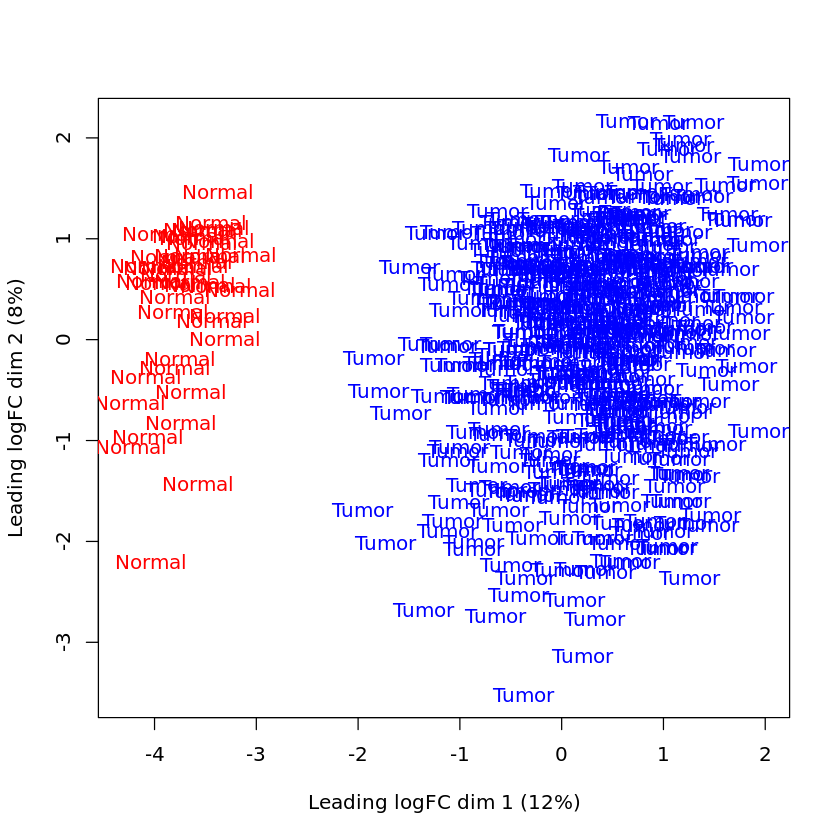

In [10]:
# Select the protein coding genes
pro_code <- data_meta[which(data_meta$gene_type == "protein_coding"),]$gene_id
pro_count <- data_count[pro_code, ]
data <- pro_count

# Select tumor ("Primary Tumor") and normal ("Solid Tissue Normal") samples
data_tumor <- data[,rownames(data_info[which(data_info$sample_type == "Primary Tumor"), ])]
data_normal <- data[,rownames(data_info[which(data_info$sample_type == "Solid Tissue Normal"), ])]
data_coad <- cbind(data_tumor, data_normal)

# keep the genes that express in at least one sample
keep <- rowSums(data_coad >0) >0
data_coad <- data_coad[keep, ]

# Remove .VersionID from gene id
cod <- data.frame(do.call('rbind',strsplit(rownames(data_coad), "[.]")))
rownames(data_coad) <- cod$X1

# MDS plot visualization
Group <- factor(c(rep("Tumor",dim(data_tumor)[2] ), rep("Normal", dim(data_normal)[2])))
y <- DGEList(counts=data_coad,group=Group)
colnames(y) <- colnames(data_coad)
dim(y)

keep <- rowSums(cpm(y)>1) > dim(data_coad)[2]*0.1
y <- y[keep,]
dim(y)

y$samples$lib.size <- colSums(y$counts)
y <- calcNormFactors(y)

plotMDS(y, labels = Group, col=c(rep("blue",dim(data_tumor)[2]),rep("red",dim(data_normal)[2])))


## 1.2 Read GTEx data
### 1.2.1 Read read dowloaded GTEx RNA-seq data

* v8, GRCh38, STAR, GENCODE V34, https://gtexportal.org/home/datasets

#### why we add the Gtex data for three reasons:
    1. The number of TCGA normal samples is small ~40 samples. 
       To get a true picture of genes that have very low expression in normal tissue across the general population it is necessary to get a much larger normal sample set. 
       The Gtex dataset adds a large number of high quality normal samples ~600 samples are added. 
       With these samples we can get a much better picture of what the "average" expression for a given gene looks like across a broad selection of the normal population. 
    2. The TCGA normals are paired normal's which mean they are tissue that looks normal that comes from cancer patients. 
       It has been shown in the literature that "paired" normal's such as this can at times have expression profiles that differ from "true" normals this is likely due to the inflamed state that can surround tumors. 
       The Gtex samples are "true" normals from patients confirmed not to have cancer or any other gut pathology.
    3. The colon is a long organ ~60 inches in length and the "beginning" or "end" of the colon are known to have somewhat different transcription profiles. 
       They collected samples from along the length of the colon from beginning to end so there is no bias in terms of what part of the normal colon we are doing our comparisons with. 
       All parts of the colon are included in the dataset.

In [11]:
# GTEx colon data is downloaded from https://gtexportal.org/home/datasets
# The label transverse and sigmoid represent samples take from the beginning or end of the colon.
colon.trans.gct <- read.delim(file="./data/gene_reads_2017-06-05_v8_colon_transverse.gct", skip=2, header = FALSE)
colon.sigm.gct <- read.delim(file="./data/gene_reads_2017-06-05_v8_colon_sigmoid.gct", skip=2, header = FALSE)
colnames(colon.trans.gct) <- colon.trans.gct[1,]
colnames(colon.sigm.gct) <- colon.sigm.gct[1,]
gtex_meta <- read.delim(file="./data/GTEx_V8_colon_SampleAttributes.txt")
rownames(colon.sigm.gct) <-colon.sigm.gct$Name
rownames(colon.trans.gct) <-colon.trans.gct$Name
table(gtex_meta$SMTSD)



   Colon - Sigmoid Colon - Transverse 
               355                326 

### 1.2.2 Data preprocessing
1. Combine 341 colon_transverse and 310 colon_sigmoid
2. Keep genes expressed in at least one of the sample
3. Remove .VersionID from gene id
4. Combine TCGA COAD RNA-seq data with GTEx colon RNA-seq data

In [12]:
#gtex_meta have filtered the miRNA part
colon.sigm <- colon.sigm.gct[,intersect(colnames(colon.sigm.gct), gtex_meta[which(gtex_meta$SMTSD == "Colon - Sigmoid"),]$SAMPID) ]
colon.trans <- colon.trans.gct[,intersect(colnames(colon.trans.gct), gtex_meta[which(gtex_meta$SMTSD == "Colon - Transverse"),]$SAMPID) ]

dim(colon.sigm)
dim(colon.trans)

[1] 56201   341

[1] 56201   310

In [13]:
table(rownames(colon.sigm) == rownames(colon.trans))


 TRUE 
56201 

In [14]:
# Combine 341 colon_transverse and 310 colon_sigmoid GTEx samples
colon.gtex <- cbind(colon.sigm, colon.trans)

# Keep genes expressed in at least one of the sample
keep <- rowSums(colon.gtex >0) >0
colon.gtex <- colon.gtex[keep, ]

# Remove .VersionID from gene id
gtx <- data.frame(do.call('rbind',strsplit(rownames(colon.gtex), "[.]")))
rownames(colon.gtex) <- gtx$X1

In [15]:
#Combine TCGA COAD RNA-seq data with GTEx colon RNA-seq data
overlap <- intersect(rownames(data_coad) ,rownames(colon.gtex))
length(overlap)
tcga_ovlp <- data_coad[overlap,]
gtex_ovlp <- colon.gtex[overlap,]
gtex_ovlp <- apply(gtex_ovlp, 2, function(x) as.numeric(as.character(x)))

tcga_gtex <- as.data.frame(cbind(tcga_ovlp, gtex_ovlp))




[1] 19075

# 1.3  Batch effect evaluation and correction
## 1.3.1 MDS for combined TCGA and GTEx before Combat-seq adjustment


[1] 15476  1173

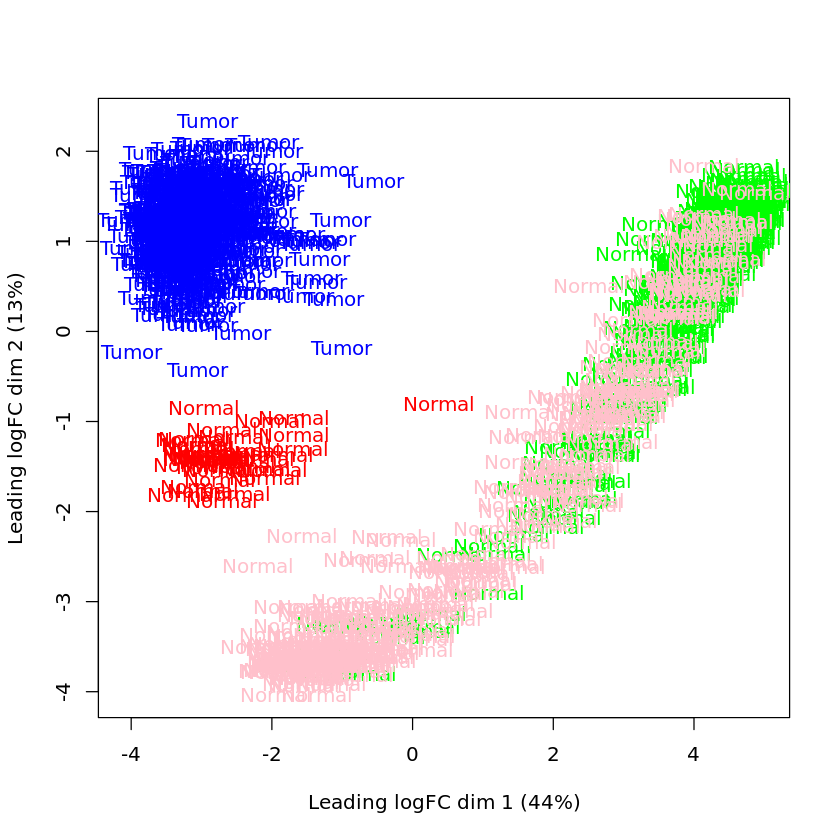

In [16]:
# Group annoation for combined TCGA and GTEx samples
Group <- factor(c(rep("Tumor",dim(data_tumor)[2] ), rep("Normal", dim(data_normal)[2]+dim(gtex_ovlp)[2])))
y <- DGEList(counts=tcga_gtex,group=Group)
colnames(y) <- colnames(tcga_gtex)

# Only keep the genes expressed with cpm >1 in > 10% of samples

keep <- rowSums(cpm(y)>1) >= dim(tcga_gtex)[2]*0.1
y <- y[keep,]
dim(y)
y$samples$lib.size <- colSums(y$counts)
y <- calcNormFactors(y)

# MDS plot to check similarity between samples
plotMDS(y, labels = Group, col=c(rep("blue",dim(data_tumor)[2]),rep("red",dim(data_normal)[2]), rep("green",dim(colon.sigm)[2]), rep("pink", dim(colon.trans)[2])))

### 1.3.2 Combat-seq adjustment
Based on the MDS plot, the batch effect is obvious, so it is necessary to remove the batch effect using Combat-seq

In [17]:
Batch <- factor(c(rep("TCGA", dim(tcga_ovlp)[2]), rep("GTEx", dim(gtex_ovlp)[2])))
adjusted <- ComBat_seq(as.matrix(tcga_gtex), batch=Batch, group=Group)


Found 2 batches
Using full model in ComBat-seq.
Adjusting for 1 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


### 1.3.3 MDS for combined TCGA and GTEx after Combat-seq adjustment

[1] 19075  1173

[1] 15491  1173

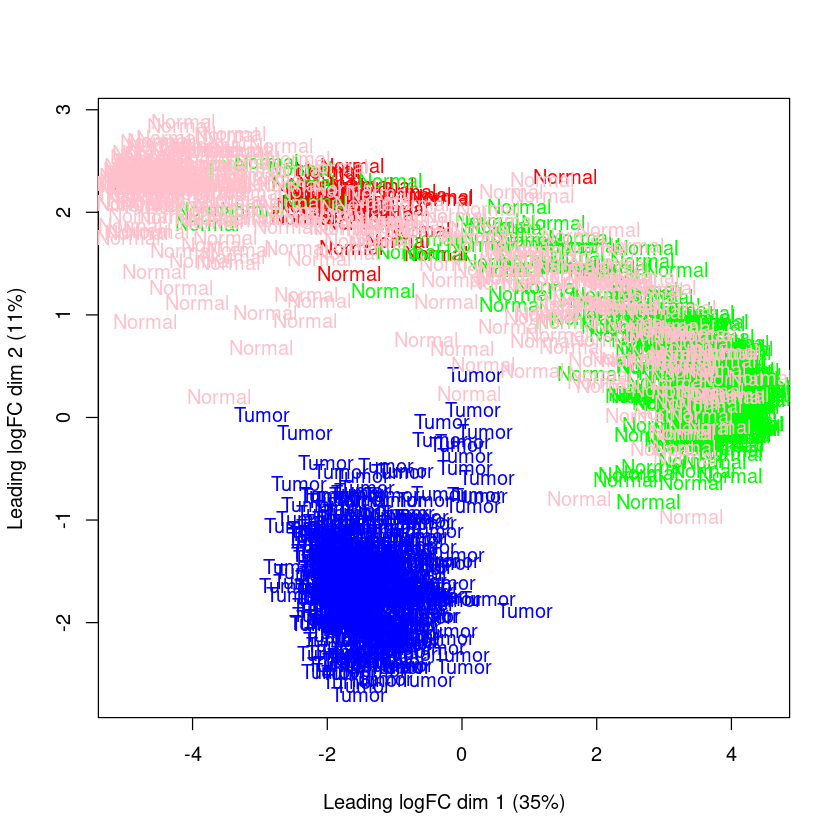

In [29]:
y <- DGEList(counts=adjusted,group=Group)
colnames(y) <- colnames(adjusted)
dim(y)
keep <- rowSums(cpm(y)>1) >= dim(adjusted)[2]*0.1
y <- y[keep,]
dim(y)
y$samples$lib.size <- colSums(y$counts)
y <- calcNormFactors(y)

plotMDS(y, labels = Group, col=c(rep("blue",dim(data_tumor)[2]),rep("red",dim(data_normal)[2]), rep("green",dim(colon.sigm)[2]), rep("pink", dim(colon.trans)[2])))

After combat-seq adjustment, batch effect is not obvious.

# 2 Differential test between ” Tumor” and “Normal” for combined TCGA_COAD and GTEx
# 2.1 Differential test


In [18]:
design <- model.matrix(~0+Group)
colnames(design)

# Estimate dispersion
x <- estimateGLMTrendedDisp(y, design)
#x <- estimateGLMCommonDisp(y, design)
fit <- glmFit(x,design,robust = TRUE)
# Likelyhood ratio DE test
lrt <- glmLRT(fit, contrast = c(-1,1))
top <- topTags(lrt, n=Inf)
# Summary the DE results
#summary(de <- decideTestsDGE(lrt))

[1] "GroupNormal" "GroupTumor"

In [19]:
result <- as.data.frame(top$table)



In [20]:
# Add adjusted reads count to the DE results
adjusted_count <- adjusted[rownames(result) ,]

#get a vector of labels suitable for AUC calculation
disease_labels=c(rep("T", dim(data_tumor)[2]), rep("TCGA_N", dim(data_normal)[2]), rep("N", ncol(adjusted_count)-dim(data_tumor)[2]))


#get a vector of labels suitable for exporting the data as a cpm data set
disease_labels_cpm=c(rep("T", dim(data_tumor)[2]), rep("TCGA_N", dim(data_normal)[2]), rep("Gtex_N", dim(gtex_ovlp)[2]))


##Converting to cpm
cpm_adjusted_count=as.data.frame(cpm(adjusted_count))

##Adding gene name to gene count matrix
cpm_adjusted_count=cbind("ID"=rownames(cpm_adjusted_count), cpm_adjusted_count)
temp=merge(IDToGene, cpm_adjusted_count, by="ID")
cpm_adjusted_count=temp

head(cpm_adjusted_count)

##Adding disease labels to dataSet
colnames(cpm_adjusted_count)[3:ncol(cpm_adjusted_count)]=disease_labels_cpm


###Writing the cmp counts for each sample to a file for use in other programs/analysis
write.table(cpm_adjusted_count,file="./Results/TCGA_GTEX_cpm_adjusted_counts_Data_table.csv",sep = ",",quote = FALSE, row.names=F)


# Add the percentage of Tumor/nomral sample expressed for each gene to the DE results
result["T_perc"] <- rowSums(cpm(adjusted_count[,1:dim(data_tumor)[2]])>1)/dim(data_tumor)[2]
result["N_perc"] <- rowSums(cpm(adjusted_count[,(dim(data_tumor)[2]+1):dim(adjusted_count)[2]])>1)/(dim(adjusted_count)[2] -dim(data_tumor)[2])

##Add median tumor and normal median
result["T_median"] <- apply(cpm(adjusted_count[,1:478]), 1, median)
result["N_median"] <- apply(cpm(adjusted_count[,479:dim(adjusted_count)[2]]), 1, median)
result["AUC"]<-apply(adjusted_count, 1, auc, response=disease_labels, quiet=TRUE)



# Add metric fold change to the DE results, which is log2FC * (T_perc + 0.001)/(N_perc + 0.001)
result["Metric_FC"]<- result$logFC * (result["T_perc"] + 0.001)/(result["N_perc"] + 0.001)
result["Metric_FC_CPM"]<- result$Metric_FC*result$logCPM 




,ID,Gene,TCGA-AA-3688-01A-01R-0905-07,TCGA-G4-6298-01A-11R-1723-07,TCGA-AA-3672-01A-01R-0905-07,TCGA-G4-6314-01A-11R-1723-07,TCGA-A6-2682-01A-01R-1410-07,TCGA-AA-3562-01A-02R-0821-07,TCGA-AA-3979-01A-01R-1022-07,TCGA-AA-3524-01A-02R-0821-07,⋯,GTEX-ZV6S-1226-SM-59HLH,GTEX-ZV7C-1526-SM-5NQ72,GTEX-ZVP2-1526-SM-5NQ82,GTEX-ZVT2-1926-SM-5GU5T,GTEX-ZXES-1626-SM-5NQ7L,GTEX-ZY6K-1226-SM-5GZYL,GTEX-ZYFC-2626-SM-5NQ6S,GTEX-ZYFG-1926-SM-5GID5,GTEX-ZYVF-2826-SM-5GIDK,GTEX-ZZ64-0726-SM-5GZX4
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,TSPAN6,316.2630070,116.8451212,20.5467820,100.0690133,180.425115,393.631366,229.245223,142.861875,⋯,25.7315985,170.659510,107.9112367,155.6829382,72.018834,77.6334734,34.2865122,27.276747,25.518439,88.6659350
2,ENSG00000000005,TNMD,0.9716221,0.4326596,0.5590961,0.7086432,3.513433,1.421229,1.231949,3.544283,⋯,0.1764856,1.686943,0.2928127,0.3205826,4.592212,0.5416289,0.2492054,1.033210,0.000000,0.2848705
3,ENSG00000000419,DPM1,110.3674423,43.4552441,6.0102832,40.9939370,41.334505,81.696151,107.538903,116.143433,⋯,31.2379488,25.495449,25.6308708,21.7395094,33.379516,27.8036160,30.5899652,28.309957,34.835798,28.7897223
4,ENSG00000000457,SCYL3,23.8489071,21.0110297,5.5909611,10.6296484,10.953644,10.389673,18.325245,17.176141,⋯,19.6251972,21.182440,19.5989294,18.2932461,16.366078,18.9770713,18.6904064,17.564572,14.115104,17.1634461
5,ENSG00000000460,C1orf112,33.4767992,8.7613560,6.8489273,10.1786936,10.436963,13.673201,31.312043,19.766195,⋯,6.1064013,3.165192,4.4702737,3.3060083,3.965082,4.1725484,5.9186287,3.967527,3.198496,4.1128175
6,ENSG00000000938,FGR,5.4764157,2.1903390,30.3309639,9.4485764,14.157068,10.977767,3.028542,4.907469,⋯,14.8953835,8.834712,16.2023022,7.8142015,42.746010,6.0782797,4.2157250,11.819924,6.257928,16.1129862


Warning message in roc.default(response, predictor, auc = TRUE, ...):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”


ERROR: Error in roc.default(response, predictor, auc = TRUE, ...): Response and predictor must be vectors of the same length.


In [ ]:
##adding the gene names, normal percentile and tumor percentile

#adding gene name
result["ensemID"]=rownames(result)
result_output=merge(result, IDToGene, by.x="ensemID", by.y="ID")

#normal percentile calculation
result_output=result_output[order(result_output$N_median, decreasing=TRUE), ]
foo=result_output
foo["N_percentile"]=1-(seq(1, nrow(foo), by=1)/nrow(foo))

#tumor percentile calculation
foo=foo[order(foo$T_median, decreasing=TRUE), ]
foo["T_percentile"]=1-(seq(1, nrow(foo), by=1)/nrow(foo))

final_results=foo

colnames(final_results)


In [35]:
write.table(final_results,file="./Results/GeneLists/total_GeneList.tsv",sep = "\t",quote = FALSE, row.names=F)

In [36]:
############### List of Genes 1 Select those genes with an AUC >0.9 with a gene expression in normal
############### tissue < 0.12 percentile so low expression in most normal samples sort this list
############### by the median tumor expression from highest to lowest.
lowBackgroundIndex=which(final_results$FDR<0.001 & final_results$AUC>0.9 & 
                         final_results$N_percentile<0.12 & final_results$logFC>2)

lowBackground_Results=final_results[lowBackgroundIndex, ]
print(c("Number of promising genes with low expression in normal samples", nrow(lowBackground_Results)))

lowBackground_Results=lowBackground_Results[order(lowBackground_Results$T_median, decreasing=TRUE), ]



## write results to a file
write.table(lowBackground_Results,file="./Results/GeneLists/lowBackground_GeneList.tsv",sep = "\t",quote = FALSE, row.names=F)




lowBackground_Results[1:10, c("logFC", "T_perc", "N_perc", "T_median", "N_median", "AUC", "Gene", "N_percentile", "T_percentile")]
#final_results[temp, c("logFC", "T_perc", "N_perc", "T_median", "N_median", "AUC", "Gene", "N_percentile", "T_percentile")]



[1] "Number of promising genes with low expression in normal samples"
[2] "98"                                                             


,logFC,T_perc,N_perc,T_median,N_median,AUC,Gene,N_percentile,T_percentile
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
9077,8.039920,0.9916318,0.008633094,95.38619,0.36426702,0.9896015,SIM2,0.061077072,0.8827475
8204,4.109755,0.9979079,0.371223022,78.91943,0.29451300,0.9375365,MMP3,0.052563689,0.8478555
776,6.461182,1.0000000,0.480575540,77.50436,0.93699695,0.9926613,COL11A1,0.119445340,0.8442438
791,6.006978,1.0000000,0.397122302,71.92273,0.84897987,0.9920231,CDH3,0.112995808,0.8276040
13786,4.490617,1.0000000,0.250359712,70.92722,0.02911157,0.9585789,MMP1,0.015349887,0.8239278
9926,6.266172,0.9874477,0.297841727,65.89261,0.58095105,0.9809021,FOXQ1,0.087584650,0.8075460
10935,4.205006,1.0000000,0.333812950,56.23802,0.25664362,0.9316757,CXCL8,0.047081587,0.7667204
4046,3.071645,0.9811715,0.155395683,54.40369,0.02011397,0.9105129,REG1A,0.006514028,0.7586585
10112,6.041742,0.9832636,0.168345324,52.17233,0.23723153,0.9684356,CLDN2,0.045469203,0.7473718


In [37]:
############### List of Genes 1 Select those genes with an AUC >0.9 and a FDR <0.001
###############  and a logFC of >2 the logFC cutoff  is to ensure the expression in tumor is higher than the expression in normal
###############sort this list by the median tumor expression from highest to lowest.

######This list is genes that we don't care very much about the background level of expression in normal just
######that the expression in cancer be very high 

highCRCIndex=which(final_results$FDR<0.001 & final_results$AUC>0.9 & final_results$logFC>2)

highCRC_Results=final_results[highCRCIndex, ]
print(c("Number of promising genes with very high expression in crc samples", nrow(highCRC_Results)))

highCRC_Results=highCRC_Results[order(highCRC_Results$T_median, decreasing=TRUE), ]

highCRC_Results[1:10, c("FDR", "T_perc", "logFC", "N_perc", "T_median", "N_median", "AUC", "Gene", "N_percentile", "T_percentile")]


## write results to a file
write.table(highCRC_Results,file="./Results/GeneLists/highCRC_GeneList.tsv",sep = "\t",quote = FALSE, row.names=F)


[1] "Number of promising genes with very high expression in crc samples"
[2] "134"                                                               


,FDR,T_perc,logFC,N_perc,T_median,N_median,AUC,Gene,N_percentile,T_percentile
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
4642,0,1.0000000,3.229163,1.000000000,1083.05029,117.851142,0.9016782,TGFBI,0.91035150,0.9965173
5028,0,1.0000000,3.647234,1.000000000,157.12461,24.006493,0.9540547,RPS10,0.54040632,0.9451145
2637,0,1.0000000,5.261627,0.946762590,142.56838,2.511497,0.9846287,CEMIP,0.19858110,0.9361496
2288,0,1.0000000,3.518322,1.000000000,140.39771,12.172762,0.9423061,SLCO4A1,0.39355047,0.9344728
1997,0,1.0000000,4.389035,0.994244604,137.68505,7.844560,0.9566645,MMP11,0.32305708,0.9325379
5624,0,1.0000000,3.250709,0.952517986,130.00290,7.951711,0.9105837,GDF15,0.32524992,0.9260884
9077,0,0.9916318,8.039920,0.008633094,95.38619,0.364267,0.9896015,SIM2,0.06107707,0.8827475
11935,0,1.0000000,5.371445,0.738129496,84.08446,1.577193,0.9864288,ETV4,0.15846501,0.8612706
15099,0,1.0000000,3.644611,1.000000000,82.78601,14.598141,0.9498585,NME2,0.42850693,0.8581748


In [38]:
# get the gene list from Wenying's filter
WY_list <- read.csv(file="data/candidate_genes_for_screening.csv",header=T,stringsAsFactors=F)

In [39]:
# literature list
lite_list <- c("MAGEA3","MYC", "LCN2")

In [40]:
# experimental verified genes
#ver_list <-c("SIM2", "CDH3", "KRT80", "NOTUM", "MMP7", "KLK6", "KRT6B", "TCN1", "DKK4", "SIM2", "CDH3", "KRT80", "NOTUM", "MMP7", "KLK6", "KRT6B", "TCN1", "DKK4", "MAGEA3", "MYC", "LCN2")
ver_list<-c("CDH3", "MYC", "MAGEA3", "DKK4", "NOTUM", "KLK6", "SIM2", "TCN1", "LCN2", "KRT6B", "KRT80", "MMP7", "KLK10", "ITGA6", "MACC1", "TGFBI", "ETV4", "HBA1", "HBA2", "MMP1", "MMP3", "MMP10", "MMP11", "CLDN2", "FOXQ1")

In [41]:
uni_list = unique(c(highCRC_Results[,"Gene"],lowBackground_Results[,"Gene"],WY_list[,"gene"],lite_list))
length(uni_list)

[1] 159

In [42]:
# all candidate genes
can_Results = final_results[na.omit(match(uni_list,final_results[,"Gene"])),]
print(dim(can_Results))
head(can_Results)

[1] 158  16


,ensemID,logFC,logCPM,LR,PValue,FDR,T_perc,N_perc,T_median,N_median,AUC,Metric_FC,Metric_FC_CPM,Gene,N_percentile,T_percentile
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
4642,ENSG00000120708,3.229163,9.273145,2104.885,0,0,1,1.0000000,1083.0503,117.851142,0.9016782,3.229163,29.94450,TGFBI,0.9103515,0.9965173
5028,ENSG00000124614,3.647234,7.181568,4397.560,0,0,1,1.0000000,157.1246,24.006493,0.9540547,3.647234,26.19286,RPS10,0.5404063,0.9451145
2637,ENSG00000103888,5.261627,6.188737,8956.293,0,0,1,0.9467626,142.5684,2.511497,0.9846287,5.557181,34.39193,CEMIP,0.1985811,0.9361496
2288,ENSG00000101187,3.518322,6.266389,4590.086,0,0,1,1.0000000,140.3977,12.172762,0.9423061,3.518322,22.04718,SLCO4A1,0.3935505,0.9344728
1997,ENSG00000099953,4.389035,6.436683,6625.174,0,0,1,0.9942446,137.6851,7.844560,0.9566645,4.414416,28.41420,MMP11,0.3230571,0.9325379
5624,ENSG00000130513,3.250709,6.353840,3974.562,0,0,1,0.9525180,130.0029,7.951711,0.9105837,3.412584,21.68301,GDF15,0.3252499,0.9260884


In [43]:
#high CRC label
highCRC <- rep(0, nrow(can_Results))
highCRC[match(highCRC_Results[,"Gene"],can_Results[,"Gene"])] = 1
#low background  label
lowBackground <- rep(0, nrow(can_Results))
lowBackground[match(lowBackground_Results[,"Gene"],can_Results[,"Gene"])] = 1
# Wenying's list label
WY <- rep(0, nrow(can_Results))
WY[match(WY_list[,"gene"],can_Results[,"Gene"])] = 1
# literature list label
literature <- rep(0, nrow(can_Results))
literature[match(lite_list,can_Results[,"Gene"])] = 1
# verified list
verified  <- rep(0, nrow(can_Results))
verified[match(ver_list,can_Results[,"Gene"])] = 1
# priority depends on the how many times the gene occur in the labels
priority = highCRC+lowBackground+WY+literature

can_label_Results <- cbind(can_Results, highCRC, lowBackground, WY, literature, verified,priority)
can_label_Results <- can_label_Results[with(can_label_Results, order(verified,-priority)),]
head(can_label_Results)
#table(can_label_Results[,"Gene"])

,ensemID,logFC,logCPM,LR,PValue,FDR,T_perc,N_perc,T_median,N_median,⋯,Metric_FC_CPM,Gene,N_percentile,T_percentile,highCRC,lowBackground,WY,literature,verified,priority
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
776,ENSG00000060718,6.461182,5.631467,11942.995,0,0,1.0000000,0.48057554,77.50436,0.9369969,⋯,75.63157,COL11A1,0.11944534,0.8442438,1,1,1,0,0,3
10935,ENSG00000169429,4.205006,5.884353,6227.428,0,0,1.0000000,0.33381295,56.23802,0.2566436,⋯,73.97709,CXCL8,0.04708159,0.7667204,1,1,1,0,0,3
12847,ENSG00000183734,3.891455,4.725175,4559.884,0,0,0.9832636,0.44892086,51.97662,0.7112249,⋯,40.22585,ASCL2,0.10016124,0.7465979,1,1,1,0,0,3
2903,ENSG00000105664,5.035578,5.206555,7743.748,0,0,0.9895397,0.21294964,43.76440,0.1359196,⋯,121.38364,COMP,0.03289262,0.6970655,1,1,1,0,0,3
339,ENSG00000015413,3.208664,5.088566,3540.451,0,0,0.9769874,0.31510791,39.87317,0.1019624,⋯,50.51467,DPEP1,0.02876491,0.6683650,1,1,1,0,0,3
3215,ENSG00000108244,7.230080,4.136939,9965.617,0,0,0.9644351,0.05467626,22.99165,0.1115076,⋯,518.65109,KRT23,0.02992583,0.5154466,1,1,1,0,0,3


## Generate gene groups for primer design experiments
## the goal is to generate a list of gene groups of size n (=8 by default) that contains all genes from sorted highCRC and lowBG list
### Algorithm
#### step a: create a new empty group A 
##### definition:
######    n_hc: the number of genes from highCRC list already in A
######    n_bg: the number of genes from lowBG list already in A
######    n_hc_pick: how many highCRC genes will be added to A
######    n_bg_pick: how many lowBG genes will be added to A
##### process:
    
###### 1. calculate how many genes (n_hc_pick, n_bg_pick) to extract from sorted highCRC and lowBG lists respectively
######         if A is empty, n_hc_pick = n_bg_pick = n/2 else caculate n_hc_pick and n_bg_pick based on the n_hc and n_bg to make 
######         the numbers of genes from highCRC and lowBG lists in A are equal as much as possible
###### 2. extract the top n_hc_pick and n_bg_pick genes from the two lists respectively, and add them to A
###### 3. remove the duplicates
###### 4. remove the genes in A from highCRC and lowBG lists
###### 5. repeat from step 1 till the total gene number in A is equal to n
#### repeat step "a" till both highCRC and lowBG lists are empty

In [44]:
highCRC_gene = highCRC_Results[is.na(match(highCRC_Results[,"Gene"],ver_list)),"Gene"]
lowBG_gene = lowBackground_Results[is.na(match(lowBackground_Results[,"Gene"],ver_list)),"Gene"]
cat("total genes:",length(unique(c(highCRC_gene,lowBG_gene))),"\n")
A <- c()
gg <- list()
n <-8
while (length(highCRC_gene)>0 | length(lowBG_gene)>0){
    n_pick <- n - length(A) 
    if (n_pick == 0){
        gg[[length(gg)+1]] = A
        A <- c()
        n_pick <- n - length(A) 
    }
    n_hc = length(!is.na(match(A,highCRC_gene)))
    n_bg = length(!is.na(match(A,lowBG_gene)))
    if ((n_hc+n_bg)>0){
        n_hc_pick = as.integer(n_pick * n_bg/(n_hc+n_bg))
        n_bg_pick = n_pick -n_hc_pick
    }else{
        n_hc_pick = as.integer(n/2)
        n_bg_pick = n - n_hc_pick
    }
    
    
    if (length(highCRC_gene)>0){
        if (n_hc_pick >0) {
            if (n_hc_pick  > length(highCRC_gene)){
                A = c(A, highCRC_gene[1:length(highCRC_gene)])
            }else{
                A = c(A, highCRC_gene[1:n_hc_pick])
            }
        }
    }
    
    
    if (length(lowBG_gene)> 0){
        if (n_bg_pick >0){
            if (n_bg_pick > length(lowBG_gene)){
                A = c(A, lowBG_gene[1:length(lowBG_gene)])
            }else{
                A = c(A, lowBG_gene[1:n_bg_pick])
            }
        }
    }
    A<- unique(A)
    if (length(lowBG_gene)>0){
        rem.ids.bg <- na.omit(match(A,lowBG_gene))
        if (length(rem.ids.bg) > 0) lowBG_gene <- lowBG_gene[-rem.ids.bg]
    }
    if (length(highCRC_gene)>0){
        rem.ids.hc <- na.omit(match(A,highCRC_gene))
        if (length(rem.ids.hc)>0) highCRC_gene <- highCRC_gene[-rem.ids.hc]
    }
}
if (length(A)>0) gg[[length(gg)+1]] <- A

total genes: 117 


In [45]:
length(unlist(gg))
group <- rep(0,nrow(can_label_Results))
for (i in c(1:length(gg))){
    ids <- match(gg[[i]],can_label_Results[,"Gene"])
    group[ids] <- i
}
ids <- match(ver_list,can_label_Results[,"Gene"])
group[which(group==0)] = i+1
group[ids] <- 1000
can_label_Results_1 <- cbind(can_label_Results,group)
head(can_label_Results_1)

## write all candidate genes
write.table(can_label_Results_1,file="./Results/GeneLists/candidate_label_GeneList.tsv",sep = "\t",quote = FALSE, row.names=F)


[1] 117

,ensemID,logFC,logCPM,LR,PValue,FDR,T_perc,N_perc,T_median,N_median,⋯,Gene,N_percentile,T_percentile,highCRC,lowBackground,WY,literature,verified,priority,group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
776,ENSG00000060718,6.461182,5.631467,11942.995,0,0,1.0000000,0.48057554,77.50436,0.9369969,⋯,COL11A1,0.11944534,0.8442438,1,1,1,0,0,3,1
10935,ENSG00000169429,4.205006,5.884353,6227.428,0,0,1.0000000,0.33381295,56.23802,0.2566436,⋯,CXCL8,0.04708159,0.7667204,1,1,1,0,0,3,1
12847,ENSG00000183734,3.891455,4.725175,4559.884,0,0,0.9832636,0.44892086,51.97662,0.7112249,⋯,ASCL2,0.10016124,0.7465979,1,1,1,0,0,3,1
2903,ENSG00000105664,5.035578,5.206555,7743.748,0,0,0.9895397,0.21294964,43.76440,0.1359196,⋯,COMP,0.03289262,0.6970655,1,1,1,0,0,3,2
339,ENSG00000015413,3.208664,5.088566,3540.451,0,0,0.9769874,0.31510791,39.87317,0.1019624,⋯,DPEP1,0.02876491,0.6683650,1,1,1,0,0,3,2
3215,ENSG00000108244,7.230080,4.136939,9965.617,0,0,0.9644351,0.05467626,22.99165,0.1115076,⋯,KRT23,0.02992583,0.5154466,1,1,1,0,0,3,4


In [46]:
# the highCRC list contains all lowBackground list
table(can_label_Results[,c("highCRC","lowBackground")])

       lowBackground
highCRC  0  1
      0 24  0
      1 36 98

In [64]:
#saving R data/results so don't have to regenerate it by running the entire script
#save.image("COAD/COAD.rda")

In [63]:
#reloading the saved R object 
#load("./COAD/COAD.rda")

In [62]:
# verification
## total number of gene groups produced
### 1000: experimental verfied; 16: gene in WY's list but not in the highCRC and lowBG list
table(can_label_Results_1[,"group"])
## all genes in highCRC and lowBG are included without duplicates in all groups
cat("duplicate genes:", length(which(table(can_label_Results_1[,"Gene"])==2)),"\n")
cat("highCRC gene not in candidate:",length(which(is.na(match(highCRC_Results[,"Gene"], can_label_Results_1[,"Gene"])))),"\n")
cat("lowBG gene not in canddiate:",length(which(is.na(match(lowBackground_Results[,"Gene"], can_label_Results_1[,"Gene"])))),"\n")


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   8    8    8    8    8    8    8    8    8    8    8    8    8    8    5   21 
1000 
  20 

duplicate genes: 0 
highCRC gene not in candidate: 0 
lowBG gene not in canddiate: 0 


In [65]:
which(is.na(can_label_Results_1[,"Gene"]))
uni_list[which(is.na(match(uni_list,final_results[,"Gene"])))]

integer(0)

[1] "APOA1"